# ANALYSIS OF FX VANILLA OPTIONS

In this notebook I show how you can analyse Vanilla European Call and Put FX options

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.fx import *
from financepy.market.volatility import *

####################################################################
# FINANCEPY BETA Version 0.220 - This build:  22 Dec 2021 at 18:22 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



C:\ProgramData\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 7004. The TBB threading layer is disabled.
  warnings.warn(problem)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1mNameError: name 'np' is not defined[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function N at 0x00000223306D11F0>))[0m
[0m[1mDuring: typing of call at C:\Users\Dominic\AppData\Roaming\Python\Python39\site-packages\financepy\models\volatility_fns.py (81)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function N at 0x00000223306D11F0>))[0m
[0m[1mDuring: typing of call at C:\Users\Dominic\AppData\Roaming\Python\Python39\site-packages\financepy\models\volatility_fns.py (81)
[0m
[1m
File "..\..\..\..\..\..\..\..\..\AppData\Roaming\Python\Python39\site-packages\financepy\models\volatility_fns.py", line 81:[0m
[1mdef vol_function_bloomberg(params, f, k, t):
    <source elided>
    d1 = np.log(f/k) / vsqrtt + vsqrtt/2.0
[1m    delta = N(d1)
[0m    [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function newton_secant at 0x000002233069EA60>))[0m
[0m[1mDuring: typing of call at C:\Users\Dominic\AppData\Roaming\Python\Python39\site-packages\financepy\market\volatility\equity_vol_surface.py (216)
[0m
[1m
File "..\..\..\..\..\..\..\..\..\AppData\Roaming\Python\Python39\site-packages\financepy\market\volatility\equity_vol_surface.py", line 216:[0m
[1mdef _solver_for_smile_strike(s, t, r, q,
    <source elided>

[1m    K = newton_secant(_delta_fit, x0=initialGuess, args=argtuple,
[0m    [1m^[0m[0m


# Creating the Option

We need to set up the option details - what you would find in the Term Sheet.

In [3]:
valuation_date = Date(10, 4, 2020)

In [4]:
forName = "EUR"
domName = "USD"
forCCRate = 0.03460  # EUR
domCCRate = 0.02940  # USD

In [5]:
dom_discount_curve = DiscountCurveFlat(valuation_date, domCCRate)
for_discount_curve = DiscountCurveFlat(valuation_date, forCCRate)

In [6]:
currency_pair = forName + domName
spot_fx_rate = 1.3465        

In [7]:
expiry_date = valuation_date.add_tenor("1Y")

In [8]:
strike_price = 1.362024

We now create the option object

In [10]:
call_option = FXVanillaOption(expiry_date, strike_price, currency_pair, OptionTypes.EUROPEAN_CALL, 1.0, "EUR")

In [11]:
print(call_option)

OBJECT TYPE: FXVanillaOption
EXPIRY DATE: 10-APR-2021
CURRENCY PAIR: EURUSD
PREMIUM CCY: EUR
STRIKE FX RATE: 1.362024
OPTION TYPE: OptionTypes.EUROPEAN_CALL
SPOT DAYS: 0
NOTIONAL: 1.0


## Valuation Dependency on Spot FX Rate

To do a valuation we need to specify the date and set the market inputs

In [12]:
spot_fx_rate = np.linspace(0.1,3.0,50)

For simplicity the discount curve is assumed to be flat here (we can pass in any discount curve) and is created as follows.

The valuation model we use is Black-Scholes which is passed in as a Black-Scholes model object. It is created as follows.

In [13]:
volatility = 0.20
model = BlackScholes(volatility)

The valuation is as follows and the output is in a dictionary

In [14]:
callValue = call_option.value(valuation_date, spot_fx_rate, dom_discount_curve, for_discount_curve, model)

In [15]:
labels = ['v', 'cash_dom', 'cash_for', 'pips_dom', 'pips_for', 'pct_dom', 'pct_for']

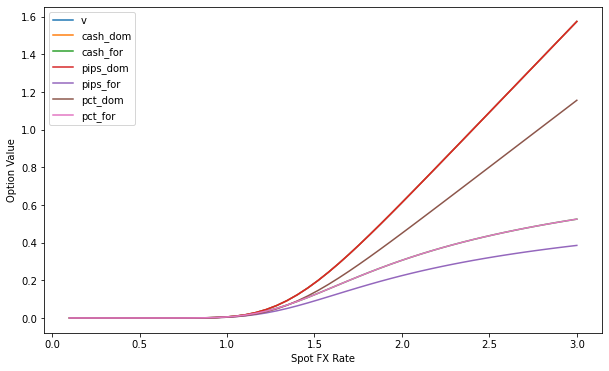

In [16]:
plt.figure(figsize=(10,6))

for labelName in labels:
    plt.plot(spot_fx_rate, callValue[labelName], label=labelName)

plt.xlabel("Spot FX Rate")
plt.ylabel("Option Value")
plt.legend();

## Delta Dependency on Spot FX Rate

In [17]:
deltaValue = call_option.delta(valuation_date, spot_fx_rate, dom_discount_curve, for_discount_curve, model)

In [18]:
labels = ['pips_spot_delta', 'pips_fwd_delta', 'pct_spot_delta_prem_adj', 'pct_fwd_delta_prem_adj']

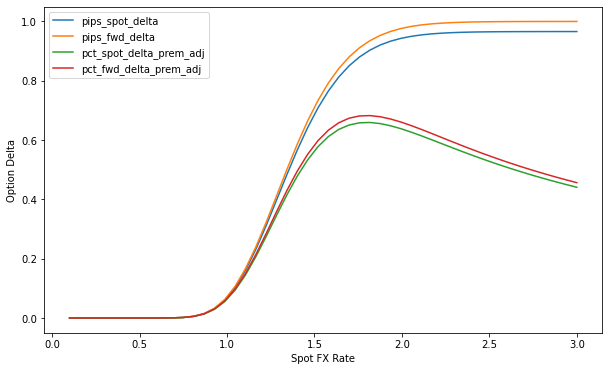

In [19]:
plt.figure(figsize=(10,6))

for labelName in labels:
    plt.plot(spot_fx_rate, deltaValue[labelName], label=labelName)

plt.xlabel("Spot FX Rate")
plt.ylabel("Option Delta")
plt.legend();

Note that the premium adjusted delta is not monotonic in the spot FX rate.

## Volatility Dependency

We can see how the value depends on volatility

In [20]:
spot_fx_rate = 1.3465

In [21]:
volatilities = np.linspace(0.01,10,100)
models = BlackScholes(volatilities)
values = call_option.value(valuation_date, spot_fx_rate, dom_discount_curve, for_discount_curve, models)

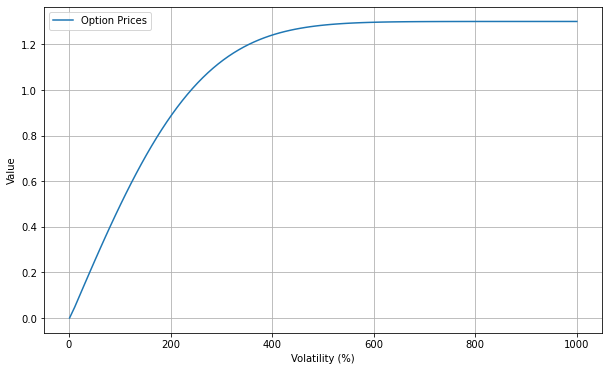

In [22]:
plt.figure(figsize=(10,6))
plt.plot(volatilities*100,values['v'], label="Option Prices")
plt.xlabel("Volatility (%)")
plt.ylabel("Value")
plt.legend()
plt.grid()

## Strike Price Dependency

We examine the strike dependency

In [23]:
strike_prices = np.linspace(0.5,3,50)

But as these are part of the option description - so we need to first vectorise those.

In [25]:
call_options = FXVanillaOption(expiry_date, strike_prices, currency_pair, OptionTypes.EUROPEAN_CALL, 1.0, "EUR")

Look, we have an array of call_options with different strikes

Then we can get back a vector of values

In [26]:
callValues = call_options.value(valuation_date, spot_fx_rate, dom_discount_curve, for_discount_curve, model)

In [27]:
labels = ['v', 'cash_dom', 'cash_for', 'pips_dom', 'pips_for', 'pct_dom', 'pct_for']

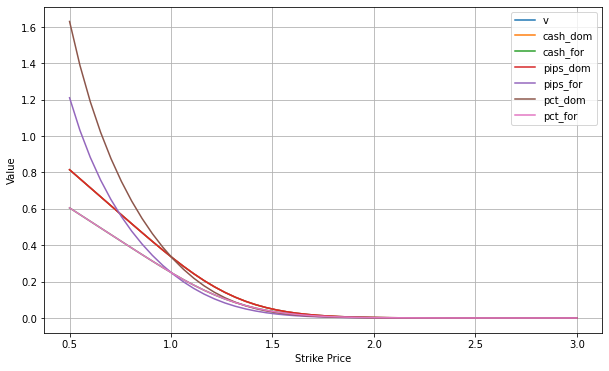

In [28]:
plt.figure(figsize=(10,6))

for labelName in labels:
    plt.plot(strike_prices, callValues[labelName], label=labelName)

plt.xlabel("Strike Price")
plt.ylabel("Value")
plt.legend()
plt.grid()

In [29]:
strike_prices = np.linspace(0.01,3,50)

In [31]:
call_options = FXVanillaOption(expiry_date, strike_prices, currency_pair, OptionTypes.EUROPEAN_CALL, 1.0, "EUR")

In [32]:
deltaValues = call_options.delta(valuation_date, spot_fx_rate, dom_discount_curve, for_discount_curve, model)

In [33]:
labels = ['pips_spot_delta', 'pips_fwd_delta', 'pct_spot_delta_prem_adj', 'pct_fwd_delta_prem_adj']

In [ ]:
plt.figure(figsize=(10,6))

for labelName in labels:
    plt.plot(strike_prices, deltaValues[labelName], label=labelName)

plt.xlabel("Strike Price")
plt.ylabel("Delta")
plt.legend()
plt.grid()

We see that the delta is not a monotonic function of the strike price.

Copyright (c) 2020, Dominic O'Kane 